In [1]:
# from roadrunner import Config
# Config.setValue(Config.PYTHON_ENABLE_NAMED_MATRIX, False)
# Config.setValue(Config.LOADSBMLOPTIONS_RECOMPILE, True)
# Config.setValue(Config.LLVM_SYMBOL_CACHE, False)
# Config.writeConfigFile('/gscratch/cheme/dalba/repos/ECFERS/my_roadrunner.config')

import os
import tellurium as te
import numpy as np
import pygmo as pg
import matplotlib.pyplot as plt

# some SBML model
modelfile = 'https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL6615119181/2/BIOMD0000000010_url.xml'

r = te.loadSBMLModel(modelfile)
r = te.loadSBMLModel(r.getParamPromotedSBML(r.getSBML()))

bin_model = 'model.b'
r.saveState(bin_model)
r.exportToSBML('model.sbml')

parameter_values = r.getGlobalParameterValues()

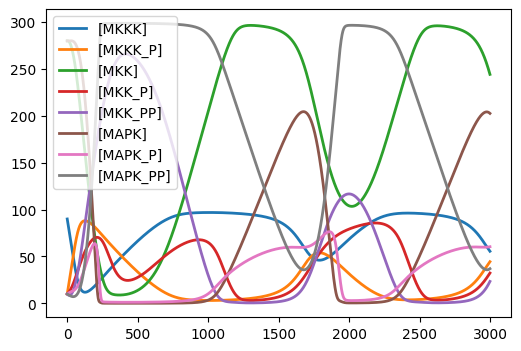

In [2]:
new_parameter_values = parameter_values*np.random.uniform(0, 1, len(parameter_values))
r.model.setGlobalParameterValues(parameter_values)

result = r.simulate(0, 3000, 5000)
r.reset()
r.plot(result)

In [41]:
class SBMLGlobalFit:

    def __init__(self, model, data, parameters, settings):
        self.model = model
        self.data = data
        self.parameters = parameters
        self.settings = settings
        self.upperb = [i*10 for i in parameters]
        self.lowerb = [i/10 for i in parameters]

    def fitness(self, x):
        r = te.loadSBMLModel(self.model)
        # # self.dview.push({'x':x}, targets=engine,block=True)
        # # if pid not in self.R:
        # #     self.R[pid] = te.loadSBMLModel(self.model)
        # #     self.value +=1
        # # self.value +=1
        # # model = open(self.model_bin_file,'rb').read()
        # # r = te.roadrunner.ExtendedRoadRunner()
        # # r.loadStateS(model)
        # # # r = te.loadSBMLModel(self.model)
        # # # r = te.loadSBMLModel(r.getParamPromotedSBML(r.getSBML()))
        # # # r = te.roadrunner.ExtendedRoadRunner()
        # # # r.loadState('model.b')
        # r.model.setGlobalParameterValues(x)
        
        # try:
        #     results = r.simulate(0, 3000, 5000)[:,1:].__array__()
        # except:
        #     results = self.data*0
        # return self._residual(results,self.data)
        return [os.getpid()]


    # def _residual(self,results,data,points):
    #     md = (np.nanmax(data,1,keepdims=True)-np.nanmin(data,1,keepdims=True))/2
    #     mr = (np.nanmax(results,1,keepdims=True)-np.nanmin(results,1,keepdims=True))/2
    #     denom = np.ones(data.shape)
    #     return [np.nansum(((data-results)/(points*(md**2+mr**2)**0.5*denom))**2)]
    def _residual(self,results,data):
        return [np.nansum(np.abs(data-results))]

    def get_bounds(self):
        return (self.lowerb, self.upperb)
    
    def get_name(self):
        return 'Global Fitting of Multiple SBML Models'

    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x),x)


In [4]:
import ipyparallel as ipp
client = ipp.Client(profile='cheme-ecfers')
dview = client[:]

load = """
        import tellurium as te
        global r
        r = te.roadrunner.ExtendedRoadRunner()
        r.loadState('/gscratch/cheme/dalba/repos/ECFERS/model.b')
        """

dview.execute(load, block=True)
models_dict = {pid:rr for pid,rr in zip(dview.apply_sync(os.getpid), dview.pull('r', block=True))}

In [42]:
udi = pg.ipyparallel_island()
udi.init_view(client_kwargs={'profile':'cheme-ecfers'})

udbfe = pg.ipyparallel_bfe()
udbfe.init_view(client_kwargs={'profile':'cheme-ecfers'})

a = pg.pso_gen(gen=10)
a.set_bfe(pg.bfe(udbfe))
algo = pg.algorithm(a)
algo.set_verbosity(1)

prob = pg.problem(SBMLGlobalFit(model = '/gscratch/cheme/dalba/repos/ECFERS/model.sbml', data = result[:,1:].__array__(), parameters=parameter_values, settings=None))
# prob = pg.problem(pg.rosenbrock(dim=10))

# my_island = pg.island(udi = udi, algo = algo, pop = pop, r_pol = pg.fair_replace(0.1), s_pol = pg.select_best(0.1))
archi = pg.archipelago(n=4,t=pg.ring(), algo=algo, prob=prob, pop_size=5, udi = udi, b = udbfe, r_pol = pg.fair_replace(0.1), s_pol = pg.select_best(0.1))

In [43]:
res =  []
for i in range(2):
    archi.evolve()
    archi.wait_check()
    res.append(np.array([a.get_algorithm().extract(pg.pso_gen).get_log()for a in archi]))
results = np.concatenate(res,axis=1)

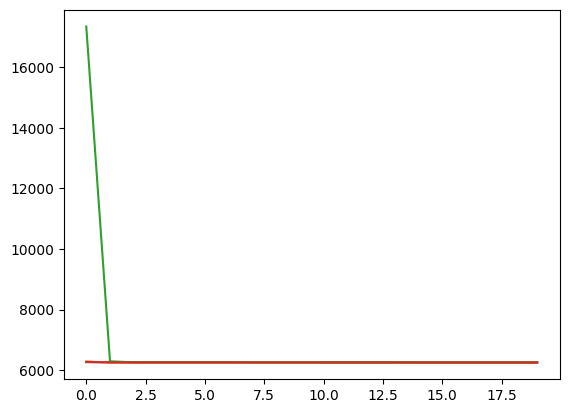

In [44]:
plt.plot(results[:,:,2].T)

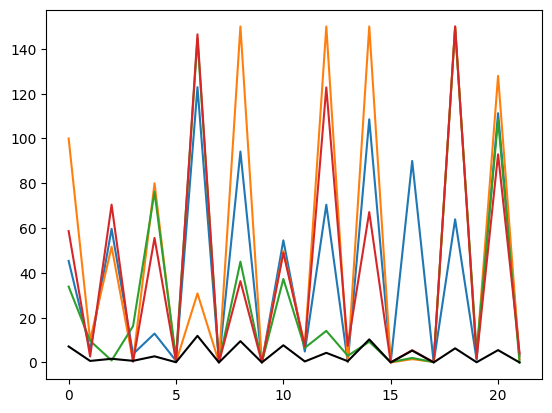

In [46]:
plt.plot(np.array(archi.get_champions_x()).T)
plt.plot(new_parameter_values,'k')

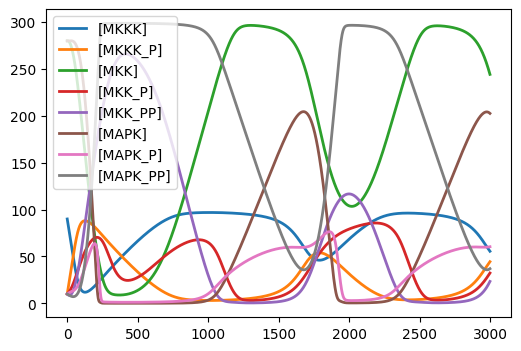

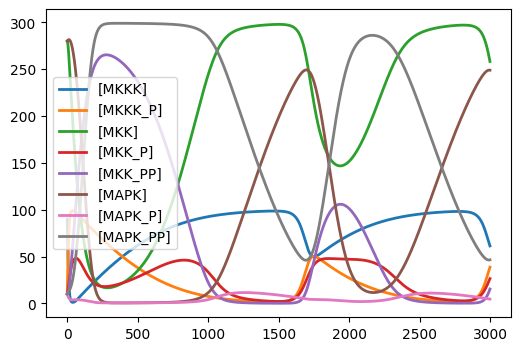

In [34]:
r.plot(result)

r.model.setGlobalParameterValues(archi.get_champions_x()[2])

result2 = r.simulate(0, 3000, 5000)
r.reset()
r.plot(result2)

In [214]:
r.getNumReactions()
r.getNumberOfIndependentSpecies()
r.getNumberOfDependentSpecies()

10

In [68]:
%px import tellurium as te
def test():
    te.roadrunner.extended_roadrunner.roadrunner.Logger_enablePythonLogging()
    te.roadrunner.extended_roadrunner.roadrunner.Logger_setFormattingPattern("%Y-%m-%d %H:%M:%S %p: %t")
    te.roadrunner.extended_roadrunner.roadrunner.Logger_setLevel(8)
    te.roadrunner.extended_roadrunner.roadrunner.Logger_enableFileLogging('/gscratch/cheme/dalba/repos/ECFERS/myllog2.log')
    r = te.roadrunner.ExtendedRoadRunner()
    r.loadState('/gscratch/cheme/dalba/repos/ECFERS/model.b')
    r.simulate(0, 3000, 5000)

udi._view.apply_sync(lambda x: test() ,1)

RemoteError: [Engine Exception] EngineError: Engine b'1015a748-8cf17f6ce6039cac39108aa3' died while running task 'cc296cbd-aa10e57c43fc2463fdea0f3f_89_1837'

In [66]:
test()

In [52]:
te.roadrunner.extended_roadrunner.roadrunner.Logger_enablePythonLogging()
te.roadrunner.extended_roadrunner.roadrunner.Logger_setFormattingPattern("%Y-%m-%d %H:%M:%S %p: %t")
te.roadrunner.extended_roadrunner.roadrunner.Logger_setLevel(8)
te.roadrunner.extended_roadrunner.roadrunner.Logger_enableFileLogging('myllog.log')

In [6]:
def test(x):
    import os
    import tellurium as te
    # from roadrunner import Config
    # Config.readConfigFile('/gscratch/cheme/dalba/repos/ECFERS/my_roadrunner2.config')
    r = te.roadrunner.ExtendedRoadRunner()
    # r.loadState('/gscratch/cheme/dalba/repos/ECFERS/model.b')
    # modelfile = 'https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL6615119181/2/BIOMD0000000010_url.xml'
    r = te.loadSBMLModel('/gscratch/cheme/dalba/repos/ECFERS/model.sbml')
    return r

def test2(x):
    from roadrunner import Config
    return Config.getValue(Config.PYTHON_ENABLE_NAMED_MATRIX)
    

In [37]:
import numpy as np
len(np.unique(np.array([a.get_population().get_f() for a in archi])))

200